# Phase 01: Data Cleaning & Normalization

This notebook handles loading, inspecting, cleaning, and preprocessing the SMS dataset.


### 1. Setup and Imports

In [14]:
import matplotlib.pyplot as plt

from src.preprocessing import DataPreprocessor
from src.config import TRAIN_SIZE, VAL_SIZE, TEST_SIZE, RANDOM_SEED, DATA_RAW_PATH, DATA_PROCESSED_PATH

### 2. Loading the data and examines its structure

In [15]:
# Initialize preprocessor
preprocessor = DataPreprocessor(random_seed=RANDOM_SEED)

# Load raw data
df_raw = preprocessor.load_data(DATA_RAW_PATH)

print("\nFirst 5 rows:")
print(df_raw.head())

print("\nDataset info:")
print(df_raw.info())

INFO:src.preprocessing:Loading data from ../data/raw/Spam_SMS.csv
INFO:src.preprocessing:Dataset shape: (5574, 2)
INFO:src.preprocessing:Data types:
label      object
message    object
dtype: object
INFO:src.preprocessing:Label distribution:
label
ham     4827
spam     747
Name: count, dtype: int64
INFO:src.preprocessing:Missing values:
label      0
message    0
dtype: int64
INFO:src.preprocessing:Duplicates: 415



First 5 rows:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5574 non-null   object
 1   message  5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


In [16]:
# Detailed data inspection
print(f"Dataset shape: {df_raw.shape}")
print(f"\nMissing values:")
print(df_raw.isnull().sum())
print(f"\nDuplicate rows: {df_raw.duplicated().sum()}")
print(f"\nLabel distribution:")
print(df_raw['label'].value_counts())
print(f"\nPercentage:")
print(df_raw['label'].value_counts(normalize=True) * 100)

Dataset shape: (5574, 2)

Missing values:
label      0
message    0
dtype: int64

Duplicate rows: 415

Label distribution:
label
ham     4827
spam     747
Name: count, dtype: int64

Percentage:
label
ham     86.598493
spam    13.401507
Name: proportion, dtype: float64


In [17]:
# Sample messages
print("Sample HAM messages:")
ham_samples = df_raw[df_raw['label'] == 'ham']['message'].head(3)
for i, msg in enumerate(ham_samples, 1):
    print(f"{i}. {msg}\n")

print("\nSample SPAM messages:")
spam_samples = df_raw[df_raw['label'] == 'spam']['message'].head(3)
for i, msg in enumerate(spam_samples, 1):
    print(f"{i}. {msg}\n")

Sample HAM messages:
1. Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

2. Ok lar... Joking wif u oni...

3. U dun say so early hor... U c already then say...


Sample SPAM messages:
1. Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

2. FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv

3. WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.



In [18]:
# Apply complete preprocessing pipeline
df_clean = preprocessor.preprocess_data(df_raw, remove_stopwords=True)

print("\nCleaned data shape:", df_clean.shape)
print("\nFirst 3 rows of cleaned data:")
print(df_clean.head(3))

INFO:src.preprocessing:Starting data preprocessing...
INFO:src.preprocessing:Removed 415 duplicate messages
INFO:src.preprocessing:Dataset shape after removing empty messages: (5159, 2)
INFO:src.preprocessing:Cleaning text data...
INFO:src.preprocessing:Dataset shape after cleaning: (5156, 2)
INFO:src.preprocessing:Tokenizing text...
INFO:src.preprocessing:Preprocessing complete. Final shape: (5156, 6)
INFO:src.preprocessing:Label distribution:
label
0    4515
1     641
Name: count, dtype: int64



Cleaned data shape: (5156, 6)

First 3 rows of cleaned data:
   label                                            message  \
0      0  go until jurong point crazy available only in ...   
1      0                            ok lar joking wif u oni   
2      1  free entry in a wkly comp to win fa cup final ...   

                                              tokens  message_length  \
0  [go, jurong, point, crazy, available, bugis, n...             102   
1                     [ok, lar, joking, wif, u, oni]              23   
2  [free, entry, wkly, comp, win, fa, cup, final,...             121   

   word_count  avg_word_length  
0          20         5.100000  
1           6         3.833333  
2          25         4.840000  


In [19]:
# Verify cleaning
print("Missing values in cleaned data:")
print(df_clean.isnull().sum())

print(f"\nNew label distribution (0=HAM, 1=SPAM):")
print(df_clean['label'].value_counts().sort_index())

print(f"\nPercentages:")
print(df_clean['label'].value_counts(normalize=True).sort_index() * 100)

Missing values in cleaned data:
label              0
message            0
tokens             0
message_length     0
word_count         0
avg_word_length    0
dtype: int64

New label distribution (0=HAM, 1=SPAM):
label
0    4515
1     641
Name: count, dtype: int64

Percentages:
label
0    87.567882
1    12.432118
Name: proportion, dtype: float64


In [20]:
# Message statistics
print("Message Length Statistics:")
print(df_clean['message_length'].describe())

print("\nWord Count Statistics:")
print(df_clean['word_count'].describe())

print("\nAverage Word Length Statistics:")
print(df_clean['avg_word_length'].describe())

Message Length Statistics:
count    5156.000000
mean       71.963538
std        52.966902
min         1.000000
25%        33.000000
50%        56.000000
75%       105.000000
max       888.000000
Name: message_length, dtype: float64

Word Count Statistics:
count    5156.000000
mean       14.724593
std        10.582262
min         1.000000
25%         7.000000
50%        12.000000
75%        21.000000
max       171.000000
Name: word_count, dtype: float64

Average Word Length Statistics:
count    5156.000000
mean        4.878620
std         0.938850
min         1.000000
25%         4.375000
50%         4.782609
75%         5.250000
max        37.000000
Name: avg_word_length, dtype: float64


### 3. Data distribution

The distribution of messages class: label
ham     4827
spam     747
Name: count, dtype: int64


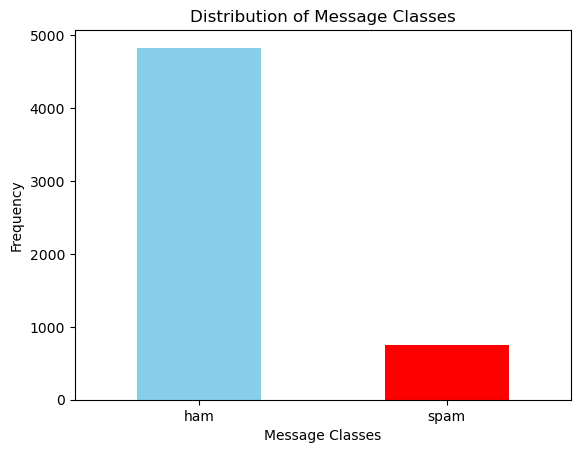

In [21]:
label_distribution = df_raw['label'].value_counts()
label_distribution.plot(kind='bar', color=['skyblue', 'red'])
plt.title('Distribution of Message Classes')
plt.xlabel('Message Classes')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
print(f"The distribution of messages class: {label_distribution}")  #TODO : make it look better
plt.show()

### 4. Data Splitting

In [22]:
# Split data
train_df, val_df, test_df = preprocessor.split_data(
    df_clean,
    train_size=TRAIN_SIZE,
    val_size=VAL_SIZE,
    test_size=TEST_SIZE
)

print(f"\nSplit complete!")
print(f"Train: {len(train_df)} ({len(train_df)/len(df_clean)*100:.1f}%)")
print(f"Val:   {len(val_df)} ({len(val_df)/len(df_clean)*100:.1f}%)")
print(f"Test:  {len(test_df)} ({len(test_df)/len(df_clean)*100:.1f}%)")

INFO:src.preprocessing:Splitting data with stratification...
INFO:src.preprocessing:Train set size: 3093 (60.0%)
INFO:src.preprocessing:Train label distribution:
label
0    2708
1     385
Name: count, dtype: int64
INFO:src.preprocessing:
Validation set size: 1031 (20.0%)
INFO:src.preprocessing:Validation label distribution:
label
0    903
1    128
Name: count, dtype: int64
INFO:src.preprocessing:
Test set size: 1032 (20.0%)
INFO:src.preprocessing:Test label distribution:
label
0    904
1    128
Name: count, dtype: int64



Split complete!
Train: 3093 (60.0%)
Val:   1031 (20.0%)
Test:  1032 (20.0%)


### 5. Save Processed Data

In [23]:
# Save processed datasets
preprocessor.save_processed_data(train_df, val_df, test_df, DATA_PROCESSED_PATH)

print(f"\nData saved to {DATA_PROCESSED_PATH}")
print("Files created:")
print("- train_data.csv")
print("- val_data.csv")
print("- test_data.csv")

INFO:src.preprocessing:Processed data saved to data/processed/



Data saved to data/processed/
Files created:
- train_data.csv
- val_data.csv
- test_data.csv


## Phase Report
1. first inspection of raw data sets showed that DataFrame consists of <mark> 5,574 entities</mark> and contains <mark> no missing data.</mark>
2. Out of the 5,574 data samples, 4,827 are classified as ham.<mark> also Some messages are duplicate</mark>, and in total there are 5,159 unique messages. The message "Sorry, I'll call later" is the most frequent one, appearing 30 times.
3. duplicate messages have been separated along with their classes. If identical messages have the same class, one instance can be kept and the rest removed in order to prevent model overfitting. However, if identical messages have different classes, they must be carefully examined to determine how they should be handled.
4. The distribution is highly <mark> imbalanced </mark> , with ham dominating the dataset (with 86.6% of instances). This is common in real-world spam detection scenarios, where legitimate messages far outnumber spam.
This means The data shows a clear <mark> skew </mark> , which might reflect real-world email traffic patterns but could lead to poor model performance on the minority class (spam) without adjustments.

5. data split into train, validation and test sets


In [24]:
print("="*60)
print("DATA PREPROCESSING SUMMARY REPORT")
print("="*60)

print(f"\nOriginal dataset size: {len(df_raw)}")
print(f"After cleaning: {len(df_clean)}")
print(f"Rows removed: {len(df_raw) - len(df_clean)}")

print(f"\nData Split:")
print(f"  Training:   {len(train_df)} messages")
print(f"  Validation: {len(val_df)} messages")
print(f"  Test:       {len(test_df)} messages")

print(f"\nClass Distribution in Training Set:")
print(f"  HAM (0):  {(train_df['label']==0).sum()} messages")
print(f"  SPAM (1): {(train_df['label']==1).sum()} messages")

print(f"\nProcessing Details:")
print(f"  ✓ Text normalized (lowercase)")
print(f"  ✓ Special characters removed")
print(f"  ✓ URLs and emails removed")
print(f"  ✓ Phone numbers removed")
print(f"  ✓ Text tokenized")
print(f"  ✓ Features engineered (length, word count, avg word length)")
print(f"  ✓ Data split with stratification")
print(f"\nReady for Phase 02: EDA & Visualization")
print("="*60)

DATA PREPROCESSING SUMMARY REPORT

Original dataset size: 5574
After cleaning: 5156
Rows removed: 418

Data Split:
  Training:   3093 messages
  Validation: 1031 messages
  Test:       1032 messages

Class Distribution in Training Set:
  HAM (0):  2708 messages
  SPAM (1): 385 messages

Processing Details:
  ✓ Text normalized (lowercase)
  ✓ Special characters removed
  ✓ URLs and emails removed
  ✓ Phone numbers removed
  ✓ Text tokenized
  ✓ Features engineered (length, word count, avg word length)
  ✓ Data split with stratification

Ready for Phase 02: EDA & Visualization
